# Expression Outliers

In [1]:
import glob
import os
import random
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns

import cardipspy as cpy
import ciepy

%matplotlib inline

In [2]:
import socket
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')

In [3]:
outdir = os.path.join(ciepy.root, 'output',
                      'expression_outliers')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'expression_outliers')
cpy.makedir(private_outdir)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

In [5]:
tdf = subject_meta[subject_meta.estimated_ethnicity == 'EUR']
a = tdf[tdf.family_id.isnull()]
b = tdf.dropna(subset=['family_id'])
b = b.drop_duplicates(subset=['family_id'])
sf = pd.concat([a, b])
print('Number to use for outliers: {}'.format(tdf.shape[0]))

Number to use for outliers: 153


In [6]:
rf = rna_meta[rna_meta.subject_id.apply(lambda x: x in sf.index)]
rf = rf.sort(columns='in_eqtl', ascending=False).drop_duplicates(subset='subject_id')

In [7]:
tpm_f = tpm[rf.index]
tpm_f = tpm_f[(tpm_f == 0).sum(axis=1) <= 4]
tpm_f = np.log10(tpm_f + 1)

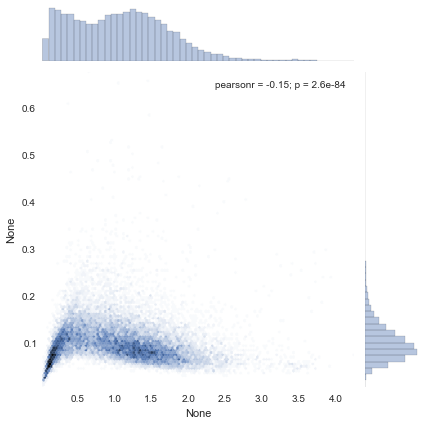

In [8]:
sns.jointplot(tpm_f.mean(axis=1), tpm_f.std(axis=1), kind='hex');

In [9]:
tpm_fn = (tpm_f.T - tpm_f.mean(axis=1)).T
tpm_fn = (tpm_fn.T / tpm_fn.std(axis=1)).T
tpm_fn = tpm_fn[gene_info.ix[tpm_fn.index, 'gene_type'] == 'protein_coding']
tpm_fn = tpm_fn[gene_info.ix[tpm_fn.index, 'chrom'].apply(lambda x: x not in ['chrX', 'chrY', 'chrM'])]

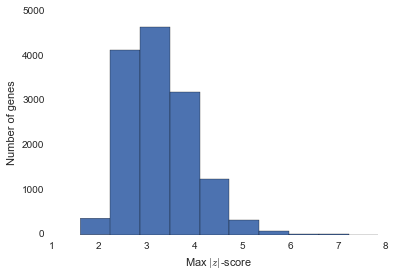

In [10]:
tpm_fn.abs().max(axis=1).hist()
plt.xlabel('Max $|z|$-score')
plt.ylabel('Number of genes');

In [11]:
m = tpm_fn.abs().max(axis=1)

In [12]:
m.sort(ascending=False)

In [13]:
gene_info.ix[m.head(10).index]

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
gene_id,,,,,,,,,
ENSG00000108846.11,ABCC3,protein_coding,chr17,48712137,48769613,+,KNOWN,HAVANA,1
ENSG00000188888.7,GPR179,protein_coding,chr17,36481412,36499730,-,KNOWN,HAVANA,2
ENSG00000177954.7,RPS27,protein_coding,chr1,153963234,153964626,+,KNOWN,HAVANA,2
ENSG00000145908.8,ZNF300,protein_coding,chr5,150273953,150284545,-,KNOWN,HAVANA,2
ENSG00000160284.10,SPATC1L,protein_coding,chr21,47581061,47604390,-,KNOWN,HAVANA,2
ENSG00000001626.10,CFTR,protein_coding,chr7,117105837,117356025,+,KNOWN,HAVANA,1
ENSG00000123975.4,CKS2,protein_coding,chr9,91926112,91931618,+,KNOWN,HAVANA,2
ENSG00000102554.9,KLF5,protein_coding,chr13,73629113,73651676,+,KNOWN,HAVANA,2
ENSG00000272617.1,RP11-343C2.12,protein_coding,chr16,69362546,69368774,-,PUTATIVE,HAVANA,2


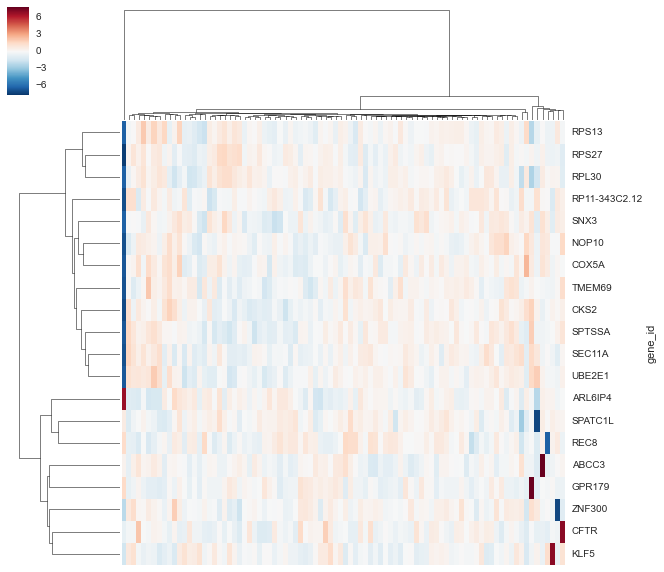

In [19]:
sns.clustermap(tpm_fn.ix[m.head(20).index], xticklabels=False, 
               yticklabels=gene_info.ix[m.head(20).index, 'gene_name']);